In [1]:
import os
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import expon, lognorm, loguniform, randint, uniform
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import altair as alt

In [2]:
survey_data = pd.read_csv('../data/raw/survey_results_public.csv')
country_selected = ['United States','Canada'] 
survey_data = survey_data.query('Country == @country_selected')

In [3]:
train_df, test_df = train_test_split(survey_data, test_size=0.2, random_state=123)

In [4]:
# Code snippet copied from https://gist.github.com/jlln/338b4b0b55bd6984f883
def splitDataFrameList(df, target_column, separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator, target_column, separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

# Code copied from 573 lecture notes
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [5]:
train_df = train_df[["DevType", "EdLevel", "YearsCodePro", "LanguageWorkedWith", "CompFreq", "CompTotal"]].dropna()
train_df = train_df.query("YearsCodePro != 'Less than 1 year' and YearsCodePro != 'More than 50 years'")

In [6]:
train_df.loc[train_df["CompFreq"] == "Monthly", "CompTotal"] *= 12
train_df.loc[train_df["CompFreq"] == "Monthly", "CompFreq"] = "Yearly"

train_df.loc[train_df["CompFreq"] == "Weekly", "CompTotal"] *= 12 * 4
train_df.loc[train_df["CompFreq"] == "Weekly", "CompFreq"] = "Yearly"

In [11]:
lower = 5000
upper = 500_000
train_df = train_df.query("CompTotal >= @lower & CompTotal <= @upper")

In [12]:
train_df = splitDataFrameList(train_df, "LanguageWorkedWith", ";")
train_df = splitDataFrameList(train_df, "DevType", ";")

X_train = train_df.drop(columns=["CompTotal"])
y_train = train_df["CompTotal"]
train_df.head(10)

,DevType,EdLevel,YearsCodePro,LanguageWorkedWith,CompFreq,CompTotal
0,"Developer, front-end",Some college/university study without earning ...,3,Bash/Shell/PowerShell,Yearly,92000.0
1,"Developer, front-end",Some college/university study without earning ...,3,C++,Yearly,92000.0
2,"Developer, front-end",Some college/university study without earning ...,3,HTML/CSS,Yearly,92000.0
3,"Developer, front-end",Some college/university study without earning ...,3,JavaScript,Yearly,92000.0
4,"Developer, front-end",Some college/university study without earning ...,3,Kotlin,Yearly,92000.0
5,"Developer, front-end",Some college/university study without earning ...,3,TypeScript,Yearly,92000.0
6,"Developer, full-stack","Bachelor’s degree (BA, BS, B.Eng., etc.)",2,Bash/Shell/PowerShell,Yearly,60000.0
7,"Developer, full-stack","Bachelor’s degree (BA, BS, B.Eng., etc.)",2,C#,Yearly,60000.0
8,"Developer, full-stack","Bachelor’s degree (BA, BS, B.Eng., etc.)",2,HTML/CSS,Yearly,60000.0
9,"Developer, full-stack","Bachelor’s degree (BA, BS, B.Eng., etc.)",2,JavaScript,Yearly,60000.0


In [13]:
train_df = train_df.astype({'YearsCodePro': 'int32'})

In [14]:
numeric_features = ["YearsCodePro"]
categorical_features = ["DevType", "EdLevel", "LanguageWorkedWith"]

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
categorical_transformer = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"),
                                       OneHotEncoder(sparse=False, handle_unknown="ignore"))

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)

pipe = make_pipeline(preprocessor, DummyRegressor())
mean_std_cross_val_scores(pipe, X_train, y_train, cv=5)

fit_time       0.327 (+/- 0.025)
score_time     0.082 (+/- 0.006)
test_score    -0.004 (+/- 0.003)
dtype: object

<AxesSubplot:ylabel='Frequency'>

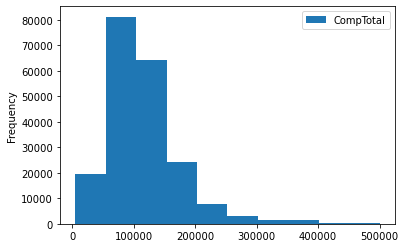

In [15]:
train_df[["CompTotal"]].plot.hist()

In [20]:
pipe_ridge = make_pipeline(preprocessor, Ridge())
mean_std_cross_val_scores(pipe_ridge, X_train, y_train, cv=5)

fit_time      0.412 (+/- 0.041)
score_time    0.083 (+/- 0.003)
test_score    0.160 (+/- 0.026)
dtype: object

In [19]:
alt.data_transformers.enable('data_server')
alt.Chart(train_df).mark_bar().encode(
    x= alt.X("CompTotal", bin=alt.Bin(maxbins = 10)),
    y = "count()"
)

alt.Chart(...)